In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import the Dataset

In [2]:
df = pd.read_excel('/kaggle/input/sarcasm/Ben-Sarc_ Bengali Sarcasm Detection Corpus.xlsx')

df.head(3)

,id,Text,Polarity
0,0,শুধু মাত্র এই পোস্টে কমেন্ট করার জন্য বাড়ির এ...,1
1,2,সাথে আছে বুক ভরা চুল ।,1
2,4,ভাই মিথ্যা কথা বইলেন না আপনি ভিপিএন ইউজ করে পো...,1


In [3]:
df.rename(columns={"Text": "text"}, inplace=True)
df.rename(columns={"Polarity": "label"}, inplace=True)

df.head(3)

,id,text,label
0,0,শুধু মাত্র এই পোস্টে কমেন্ট করার জন্য বাড়ির এ...,1
1,2,সাথে আছে বুক ভরা চুল ।,1
2,4,ভাই মিথ্যা কথা বইলেন না আপনি ভিপিএন ইউজ করে পো...,1


## Apply Normalizer

In [4]:
pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-2sh2k46w
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-2sh2k46w
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=365c82cfb0b1f5d05f4bb24cee89f561ea76430b44cc9a0f0bb578513b82ddea
  Stored in directory: /tmp/pip-ephem-wheel-cache-qyzv10ft/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=682dd65fe61e73e7c1cb90d6a66363c27715b96

In [5]:
from normalizer import normalize 
from tqdm import tqdm

tqdm.pandas()
df['text'] = df['text'].progress_apply(normalize)

100%|██████████| 25636/25636 [00:04<00:00, 5710.69it/s]


In [6]:
df['rtext'] = df['text'].progress_apply(lambda x: ' '.join(x.split()[::-1]))

100%|██████████| 25636/25636 [00:00<00:00, 324136.57it/s]


In [7]:
ri = 2
df['text'][ri], df['label'][ri]

('ভাই মিথ্যা কথা বইলেন না আপনি ভিপিএন ইউজ করে পোস্ট দিয়েছেন এবং আপনি রঙিন দুনিয়া দেখছেন না । কারণ আপনার ফ্রেম রঙিন হলেও গ্লাসটা কিন্তু কালো । আমি কিন্তু রঙিন দুনিয়ার একজন রঙমিস্ত্রি তাই বিষয়টি এড়িয়ে যেতে পারলাম না ।',
 1)

In [8]:
df.label.value_counts()

label
1    12818
0    12818
Name: count, dtype: int64

In [9]:
df.shape

(25636, 4)

In [10]:
from sklearn.model_selection import train_test_split

# Assume 'df' is your DataFrame and 'label_column' is the column you want to stratify on
# df, _ = train_test_split(df, train_size=1000, stratify=df['label'], random_state=42)

In [11]:
print(df.shape)
df.head(3)

(25636, 4)


,id,text,label,rtext
0,0,শুধু মাত্র এই পোস্টে কমেন্ট করার জন্য বাড়ির এ...,1,ছিলাম বসে কিনে বি এম করে বিক্রি ঘোড়া পাড়া ডি...
1,2,সাথে আছে বুক ভরা চুল ।,1,। চুল ভরা বুক আছে সাথে
2,4,ভাই মিথ্যা কথা বইলেন না আপনি ভিপিএন ইউজ করে পো...,1,। না পারলাম যেতে এড়িয়ে বিষয়টি তাই রঙমিস্ত্র...


## Training On MLM

In [12]:
sentences = df.text.values.tolist()

labels = df.label.values.tolist()

print(len(sentences))

print(len(labels))

25636
25636


In [13]:
sentences[0]

'শুধু মাত্র এই পোস্টে কমেন্ট করার জন্য বাড়ির এক মাত্র ডিম পাড়া ঘোড়া বিক্রি করে এম বি কিনে বসে ছিলাম'

In [14]:
# Specify the model path

model_path = "csebuetnlp/banglabert_large"
# model_path = "csebuetnlp/banglabert"

In [15]:
# import os
# os.environ["WANDB_DISABLED"] = "true"
# os.environ["WANDB_MODE"] = "disabled"
# os.environ["WANDB_SILENT"] = "true"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# from transformers import (
#     AutoModelForMaskedLM,
#     AutoTokenizer,
#     DataCollatorForLanguageModeling,
#     Trainer,
#     TrainingArguments
# )

# import torch
# from datasets import Dataset
# import gc

# model_path = "csebuetnlp/banglabert_large"

# # Dataset
# dataset = Dataset.from_dict({"text": sentences[:500]})

# # Tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_path)

# def tokenize_function(examples):
#     return tokenizer(
#         examples["text"],
#         padding="max_length",
#         truncation=True,
#         max_length=32,  # Reduced
#         return_special_tokens_mask=True
#     )

# tokenized_dataset = dataset.map(
#     tokenize_function,
#     batched=True,
#     remove_columns=dataset.column_names
# )

# # Model and Data Collator
# mlm_model = AutoModelForMaskedLM.from_pretrained(model_path)
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer,
#     mlm=True,
#     mlm_probability=0.15
# )

# Epochs = 2

# # Training Arguments
# training_args = TrainingArguments(
#     output_dir="./mlm_pretrained_model",
#     report_to=[],
#     num_train_epochs=Epochs,  # Define Epochs earlier
#     per_device_train_batch_size=8,  # Reduced
#     gradient_accumulation_steps=2,
#     save_strategy="no",
#     logging_strategy="epoch",
#     learning_rate=5e-5,
#     weight_decay=0.01,
#     fp16=True,  # Mixed precision
# )

# # Trainer
# trainer = Trainer(
#     model=mlm_model,
#     args=training_args,
#     train_dataset=tokenized_dataset,
#     data_collator=data_collator,
# )

# # Train and Save
# trainer.train()
# trainer.save_model("./mlm_pretrained_model")

# # Clear memory
# del mlm_model, trainer, tokenized_dataset, data_collator
# gc.collect()
# torch.cuda.empty_cache()

# # Now proceed to your main BERT training code

In [16]:
# First, disable wandb

import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Import required libraries
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

In [17]:
import torch
from datasets import Dataset

# Prepare your text data
# your_unlabeled_texts = df.parent_comm.values.tolist()

# Create dataset
# dataset = Dataset.from_dict({"text": sentences[:500]})
dataset = Dataset.from_dict({"text": sentences})


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=64,
        return_special_tokens_mask=True
)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  শুধু মাত্র এই পোস্টে কমেন্ট করার জন্য বাড়ির এক মাত্র ডিম পাড়া ঘোড়া বিক্রি করে এম বি কিনে বসে ছিলাম
Tokenized:  ['শুধু', 'মাত্র', 'এই', 'পোস্টে', 'কমেন্ট', 'করার', 'জন্য', 'বাড়ির', 'এক', 'মাত্র', 'ডিম', 'পাড়া', 'ঘোড়া', 'বিক্রি', 'করে', 'এম', 'বি', 'কিনে', 'বসে', 'ছিলাম']
Token IDs:  [1289, 1768, 830, 12098, 8764, 1121, 900, 2095, 788, 1768, 5270, 9224, 8046, 3149, 792, 1611, 797, 3597, 1346, 3285]


In [19]:
# Tokenize dataset
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=dataset.column_names
)

Map:   0%|          | 0/25636 [00:00<?, ? examples/s]

## Load MLM Model

In [20]:
print(model_path)

csebuetnlp/banglabert_large


In [21]:
# Load model for MLM
mlm_model = AutoModelForMaskedLM.from_pretrained(model_path)
# Create data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# mlm_model

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at csebuetnlp/banglabert_large and are newly initialized: ['generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_predictions.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
Epochs = 5

In [23]:
# Setup training arguments without automatic saving.
training_args = TrainingArguments(
    output_dir="./mlm_pretrained_model",  # still required for logs etc.
    report_to=[],                         # Disable all integrations
    num_train_epochs=Epochs,
    per_device_train_batch_size=16,
    save_strategy="no",                   # Disable automatic saving
    logging_strategy="epoch",
    learning_rate=5e-5,
    weight_decay=0.01,
)

In [24]:
# Initialize trainer
trainer = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

In [25]:
# Start Training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
802,7.327400
1604,6.118200
2406,5.628000
3208,5.306500
4010,5.087300


TrainOutput(global_step=4010, training_loss=5.893465981043485, metrics={'train_runtime': 4113.0983, 'train_samples_per_second': 31.164, 'train_steps_per_second': 0.975, 'total_flos': 1.493344524632064e+16, 'train_loss': 5.893465981043485, 'epoch': 5.0})

In [26]:
# Save the model

import os
import torch

def save_model_contiguous(model, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    state_dict = model.state_dict()
    contiguous_state_dict = {k: v.contiguous() for k, v in state_dict.items()}
    torch.save(contiguous_state_dict, os.path.join(output_dir, "pytorch_model.bin"))
    # If your model has a configuration saved, also save it:
    if hasattr(model, "config"):
        model.config.save_pretrained(output_dir)
    print(f"Model saved to {output_dir} (all tensors are now contiguous)")

# Example usage:
# output_dir = "./mlm_pretrained_model"
# save_model_contiguous(mlm_model, output_dir)


trainer.save_model("./mlm_pretrained_model")

In [27]:
# Check memory before cleanup
def print_gpu_memory(step=""):
    allocated = torch.cuda.memory_allocated() / 1024**2  # GiB
    reserved = torch.cuda.memory_reserved() / 1024**2    # GiB
    print(f"{step} - Allocated: {allocated:.2f} GiB, Reserved: {reserved:.2f} GiB")

print_gpu_memory("Before cleanup")

# Clear memory
del mlm_model
del trainer
del tokenized_dataset
del data_collator
import gc
gc.collect()
torch.cuda.empty_cache()

print_gpu_memory("After cleanup")

# Now run your main training code
# [Insert your main training code here]
# print_gpu_memory("Before main training")

Before cleanup - Allocated: 3869.36 GiB, Reserved: 6758.00 GiB
After cleanup - Allocated: 16.25 GiB, Reserved: 60.00 GiB


In [28]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Now you can load this for classification
# model = AutoModelForSequenceClassification.from_pretrained(
#     "./mlm_pretrained_model",
#     num_labels=2,
#     output_attentions=False,
#     output_hidden_states=False,
# )

new_model_path = "/kaggle/working/mlm_pretrained_model"

In [29]:
# import pandas as pd
# import json

# # Read the JSONL file
# data_train = []
# with open('/kaggle/input/sarcasm/sarcasm_detection_shared_task_reddit_training.jsonl', 'r') as f:
#     for line in f:
#         # Parse each line as JSON and append to list
#         data_train.append(json.loads(line))
# data_twitter_df = pd.DataFrame(data_train)
# # Convert list of dictionaries to Data

In [30]:
# data_twitter_df['label']=data_twitter_df['label'].map({'SARCASM':0,'NOT_SARCASM':1})
# data_twitter_df=data_twitter_df.rename(columns={'context':'parent_comment','response':'comment'})

In [31]:
# data_twitter_df.head(3)

In [32]:
# data_twitter_df['comment']=data_twitter_df['comment'].astype(str)
# data_twitter_df['parent_comment']=data_twitter_df['parent_comment'].astype(str)

In [33]:
import torch
from torch.utils.data import Dataset

class MultiFeatureDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment = dataframe['comment']
        self.parent=dataframe['parent_comment']
        self.labels = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if index >= len(self.data):
            raise IndexError(f"Index {index} out of range")
        comment = str(self.comment.iloc[index])
        parent = str(self.parent.iloc[index])
        label = self.labels.iloc[index]


 
        comment_encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        parent_encoding = self.tokenizer.encode_plus(
            parent,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
        'input_ids1': parent_encoding['input_ids'].flatten(),
        'attention_mask1': parent_encoding['attention_mask'].flatten(),
        'input_ids2': comment_encoding['input_ids'].flatten(),
        'attention_mask2': comment_encoding['attention_mask'].flatten(),
        'labels': torch.tensor(label, dtype=torch.long)
    }

In [34]:
# print(data_twitter_df.shape)
# data_twitter_df.head(3)

In [35]:
# df.rename(columns={"Polarity": "label"}, inplace=True)
df.rename(columns={"text": "parent_comment"}, inplace=True)
df.rename(columns={"rtext": "comment"}, inplace=True)

df.head(3)

,id,parent_comment,label,comment
0,0,শুধু মাত্র এই পোস্টে কমেন্ট করার জন্য বাড়ির এ...,1,ছিলাম বসে কিনে বি এম করে বিক্রি ঘোড়া পাড়া ডি...
1,2,সাথে আছে বুক ভরা চুল ।,1,। চুল ভরা বুক আছে সাথে
2,4,ভাই মিথ্যা কথা বইলেন না আপনি ভিপিএন ইউজ করে পো...,1,। না পারলাম যেতে এড়িয়ে বিষয়টি তাই রঙমিস্ত্র...


In [36]:
data_twitter_df = df.copy()

In [37]:
n_samples = 1000  # Change this as needed

sampled_df = data_twitter_df.sample(n=n_samples, random_state=42) if len(data_twitter_df) > n_samples else data_twitter_df

In [38]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(data_twitter_df, test_size=0.2, random_state=42, stratify=data_twitter_df['label'])

print(len(train_df), len(eval_df))

20508 5128


In [39]:
train_df.head(3)

,id,parent_comment,label,comment
24108,24487,আমার ভাই এবং বাবাকে নিয়ে নােয়াখালী সদর থানায...,0,। পারেনি দিতে সন্ধান কোন আমাকে তারা চাইলে সন্ধ...
16703,11100,যদি ডট বল করাতে চাও তবে আমাকে ডাকো সুনীল নারিন...,0,। পানি বোতল এক ভিতর মরুভুমির । ছেলে সোনার আমাদ...
9138,22963,কেউ অক্সিজেন না পেয়ে মরে আর কেউ বিয়ে করে মরে ।,1,। মরে করে বিয়ে কেউ আর মরে পেয়ে না অক্সিজেন কেউ


In [40]:
train_df.label.value_counts()

label
0    10254
1    10254
Name: count, dtype: int64

In [41]:
eval_df.label.value_counts()

label
1    2564
0    2564
Name: count, dtype: int64

In [42]:
# mlm_model.config.hidden_size

In [43]:
from transformers import AutoConfig, AutoModel, AutoTokenizer, logging
import torch
import torch.nn as nn

# Suppress unnecessary warnings
logging.set_verbosity_error()

class CustomEncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, dropout_rate=0.3):
        super(CustomEncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(hidden_size, num_attention_heads, dropout=dropout_rate)
        self.cross_attention = nn.MultiheadAttention(hidden_size, num_attention_heads, dropout=dropout_rate)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.layer_norm3 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, y, x_mask, y_mask):
        # Self-attention on x
        temp1 = x
        self_attn_output, _ = self.self_attention(x, x, x)
        x = self.layer_norm1(temp1 + self.dropout(self_attn_output))
        
        # Cross-attention from x to y
        cross_attn_output, cross_attn_weights = self.cross_attention(x, y, y)
        x = self.layer_norm2(temp1 + self.dropout(cross_attn_output))
        
        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.layer_norm3(temp1 + self.dropout(ff_output))
        
        return x, cross_attn_weights

class CustomDualBanglaBERTModel(nn.Module):
    def __init__(self, model_checkpoint, num_layers=6, hidden_size=1024, num_attention_heads=8, dropout_rate=0.1):
        super(CustomDualBanglaBERTModel, self).__init__()
        
        # Load BanglaBERT Electra-based models
        self.bert1 = AutoModel.from_pretrained(model_checkpoint)
        self.bert2 = AutoModel.from_pretrained(model_checkpoint)
        
        # Custom encoder layers
        self.encoder_layers = nn.ModuleList([
            CustomEncoderLayer(hidden_size, num_attention_heads, dropout_rate)
            for _ in range(num_layers)
        ])
        
        # Classification head
        self.fc = nn.Linear(hidden_size * 2, 2)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # Get embeddings from two BERT models
        output1 = self.bert1(input_ids=input_ids1, attention_mask=attention_mask1).last_hidden_state
        output2 = self.bert2(input_ids=input_ids2, attention_mask=attention_mask2).last_hidden_state
        
        # Attention masks for padding tokens
        x_mask = ~attention_mask1.bool()
        y_mask = ~attention_mask2.bool()
        
        # Apply encoder layers
        for layer in self.encoder_layers:
            output1, _ = layer(output1, output2, x_mask, y_mask)
            output2, cross_attn_weights = layer(output2, output1, y_mask, x_mask)
        
        # Pool the outputs from both models
        pooled_output1 = torch.mean(output1, dim=1)
        pooled_output2 = torch.mean(output2, dim=1)
        
        # Combine and classify
        combined = torch.cat((pooled_output1, pooled_output2), dim=1)
        return self.fc(combined)

In [44]:
model_path 

'csebuetnlp/banglabert_large'

In [45]:
# Example usage
# model_checkpoint = 'csebuetnlp/banglabert'
model_checkpoint = "/kaggle/working/mlm_pretrained_model"
# model_checkpoint = model_path
model = CustomDualBanglaBERTModel(model_checkpoint=model_checkpoint)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
model.cuda()

CustomDualBanglaBERTModel(
  (bert1): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-23): 24 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm)

In [46]:
# Calculate the total number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Each parameter takes 4 bytes (float32)
param_size_in_bytes = trainable_params * 4

# Convert to GB
param_size_in_gb = param_size_in_bytes / (1024**3)
print(f"Approximate Model Size in Memory: {param_size_in_gb:.2f} GB")

Approximate Model Size in Memory: 2.88 GB


In [47]:
# import torch
# import torch.nn as nn
# from transformers import  BertConfig,AutoModel

# class CustomEncoderLayer(nn.Module):
#     def __init__(self, hidden_size, num_attention_heads, dropout_rate=0.1):
#         super(CustomEncoderLayer, self).__init__()
#         self.self_attention = nn.MultiheadAttention(hidden_size, num_attention_heads, dropout=dropout_rate)
#         self.cross_attention = nn.MultiheadAttention(hidden_size, num_attention_heads, dropout=dropout_rate)
#         self.feed_forward = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size * 4),
#             nn.ReLU(),
#             nn.Linear(hidden_size * 4, hidden_size)
#         )
#         self.layer_norm1 = nn.LayerNorm(hidden_size)
#         self.layer_norm2 = nn.LayerNorm(hidden_size)
#         self.layer_norm3 = nn.LayerNorm(hidden_size)
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, x, y):
#         # Self-attention on x
#         e=x
#         self_attn_output, _ = self.self_attention(x, x, x)
#         x = self.layer_norm1(e + self.dropout(self_attn_output))
        
#         # Cross-attention from x to y
#         cross_attn_output, cross_attn_weights = self.cross_attention(x, y, y)
#         x = self.layer_norm2(e + self.dropout(cross_attn_output))
        
#         # Feed forward
#         ff_output = self.feed_forward(x)
#         x = self.layer_norm3(e + self.dropout(ff_output))
        
#         return x, cross_attn_weights

# class CustomDualBERTModel(nn.Module):
#     def __init__(self, num_layers=3, hidden_size=768, num_attention_heads=8, dropout_rate=0.1):
#         super(CustomDualBERTModel, self).__init__()
        
#         # Two BERT models: one for each input
#         self.bert1 = AutoModel.from_pretrained('bert-base-uncased')
#         self.bert2 = AutoModel.from_pretrained('bert-base-uncased')
        
#         self.encoder_layers = nn.ModuleList([
#             CustomEncoderLayer(hidden_size, num_attention_heads, dropout_rate)
#             for _ in range(num_layers)
#         ])
        
#         self.fc = nn.Linear(hidden_size * 2, 2)

#     def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
#         # Get BERT embeddings from two different models
#         output1 = self.bert1(input_ids=input_ids1, attention_mask=attention_mask1).last_hidden_state
#         output2 = self.bert2(input_ids=input_ids2, attention_mask=attention_mask2).last_hidden_state
        
#         # Create attention masks
#         x_mask = ~attention_mask1.bool()
#         y_mask = ~attention_mask2.bool()
        
#         # Apply custom encoder layers (self-attention and cross-attention)
#         for layer in self.encoder_layers:
#             output1, _ = layer(output1, output2)
#             output2, cross_attn_weights = layer(output2, output1)
#         # Pool the outputs from both BERTs
#         pooled_output1 = torch.mean(output1, dim=1)
#         pooled_output2 = torch.mean(output2, dim=1)
        
#         # Combine and classify
#         combined = torch.cat((pooled_output1, pooled_output2), dim=1)
#         return self.fc(combined)


In [48]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, AdamW,AutoModel,AutoTokenizer
from tqdm import tqdm  # Import tqdm for progress bars

# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 2
EPOCHS = 2
LEARNING_RATE = 2e-5

# tokenizer = AutoTokenizer.from_pretrained(model_path)

# Create data loaders
train_dataset = MultiFeatureDataset(train_df, tokenizer, MAX_LEN)
val_dataset = MultiFeatureDataset(eval_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [49]:
# Initialize the model

# Usage
# model = CustomDualBERTModel()
#model.load_state_dict(torch.load('dual_bert_classifier.pth'))


# Optimizer with weight decay
from transformers import AdamW, get_linear_schedule_with_warmup


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [50]:
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 2e-05
    weight_decay: 0.01
)

In [51]:
# mlm_model

In [52]:
import gc
import torch

# Delete any unnecessary objects, e.g., big tensors or models you no longer need
# del mlm_model  
# del model

# Run garbage collector
gc.collect()

# If you’re using PyTorch, clear GPU cache
torch.cuda.empty_cache()

In [53]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# import torch
# Now you can continue with your PyTorch code


In [54]:
# model

In [55]:
# Custom function to save the model
def save_model(model, filepath, epoch, val_accuracy, best_val_accuracy):
    """
    Save the model if the current validation accuracy is higher than the best seen so far.
    """
    if val_accuracy > best_val_accuracy:
        torch.save(model.state_dict(), filepath)
        print(f"Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.2f}%")
        return val_accuracy  # Update best validation accuracy
    return best_val_accuracy  # Keep the previous best validation accuracy

# Training loop with model saving
best_val_accuracy = 0.0  # Initialize the best validation accuracy
model_filepath = 'dual_bert_classifier_best.pth'

In [56]:
# TRaining LOOP
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Initialize the tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        text_input_ids1 = batch['input_ids1'].to(device)
        text_attention_mask1 = batch['attention_mask1'].to(device)
        text_input_ids2 = batch['input_ids2'].to(device)
        text_attention_mask2 = batch['attention_mask2'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(text_input_ids1, text_attention_mask1, text_input_ids2, text_attention_mask2)
        
        # Calculate loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        avg_loss = running_loss / (batch_idx + 1)

        # Update the progress bar with the average loss
        progress_bar.set_postfix(avg_loss=avg_loss)

    # Optional: Print statistics at the end of each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_train / total_train
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
            text_input_ids1 = batch['input_ids1'].to(device)
            text_attention_mask1 = batch['attention_mask1'].to(device)
            text_input_ids2 = batch['input_ids2'].to(device)
            text_attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(text_input_ids1, text_attention_mask1, text_input_ids2, text_attention_mask2)
            val_loss += nn.CrossEntropyLoss()(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch {epoch+1}/{EPOCHS}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Save the model if validation accuracy improves
    best_val_accuracy = save_model(model, model_filepath, epoch, val_accuracy, best_val_accuracy)

Epoch [1/2], Loss: 0.6636, Accuracy: 0.5767


Epoch 1/2, Validation Loss: 0.7001, Validation Accuracy: 50.00%
Model saved at epoch 1 with validation accuracy: 50.00%


Epoch [2/2], Loss: 0.6966, Accuracy: 0.4945


Epoch 2/2, Validation Loss: 0.6933, Validation Accuracy: 50.00%


In [57]:
# Define the model checkpoint and path to the saved weights
# model_checkpoint = 'csebuetnlp/banglabert'


saved_model_path = 'dual_bert_classifier_best.pth'


# Recreate the model architecture
model = CustomDualBanglaBERTModel(model_checkpoint=model_checkpoint)

# Load the model weights from the saved file
model.load_state_dict(torch.load(saved_model_path))

# Send the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Custom model loaded successfully!")

<ipython-input-57-7872ffada0ea>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


Custom model loaded successfully!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0:
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000
Class 1:
  Precision: 0.5000
  Recall:    1.0000
  F1 Score:  0.6667

Average Precision: 0.2500
Average Recall:    0.5000
Average F1 Score:  0.3333
Accuracy: 0.5000
Class Distribution: {0: 2564, 1: 2564}
Total Samples: 5128


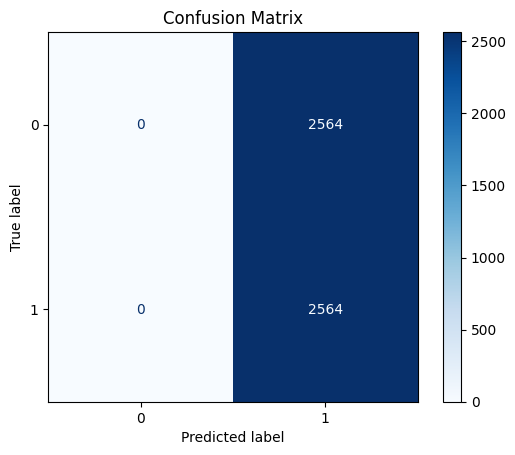

In [58]:

from tqdm import tqdm

def batch_predict(loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Batch Prediction", leave=False):
            text_input_ids1 = batch['input_ids1'].to(device)
            text_attention_mask1 = batch['attention_mask1'].to(device)
            text_input_ids2 = batch['input_ids2'].to(device)
            text_attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(text_input_ids1, text_attention_mask1, text_input_ids2, text_attention_mask2)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions
pred=batch_predict(val_loader)
true=val_dataset.labels

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from sklearn.preprocessing import label_binarize


# Generate predictions and true labels

pred = np.array(pred)
true_labels =np.array(true)



# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred, average=None)

# Get the unique labels
labels =np.array([0,1])

# Print the precision, recall, and F1 score for each class
for i, label in enumerate(labels):
    print(f"Class {label}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")

# Optionally, you can calculate the average scores
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(true_labels, pred, average='weighted')

print(f"\nAverage Precision: {avg_precision:.4f}")
print(f"Average Recall:    {avg_recall:.4f}")
print(f"Average F1 Score:  {avg_f1:.4f}")

# Compute accuracy
accuracy = accuracy_score(true_labels, pred)
print(f'Accuracy: {accuracy:.4f}')

# Print the number of samples for each class and total samples
unique, counts = np.unique(true_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
total_samples = len(true_labels)
print(f'Class Distribution: {class_distribution}')
print(f'Total Samples: {total_samples}')

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [59]:
eval_df.head(3)

,id,parent_comment,label,comment
3524,7682,পরীমনির পেজের প্রফাইলটা দেখেন ও মানুষ না আর্জে...,1,উচিৎ থাকা লজ্জা ছি বইচে ঝর প্রশংসার আবার নিয়ে...
11178,27904,ঢপ এর চপ এমন ভাও খাচ্ছে যেনো বোকাচোদার সিরিয়াল,1,সিরিয়াল বোকাচোদার যেনো খাচ্ছে ভাও এমন চপ এর ঢপ
24525,25185,হেলমেট ছাড়া বেরোলে ঠিকই কেউ না কেউ বলবে ওদিকে...,0,ধরছে পুলিশ না যাবেন ওদিকে বলবে কেউ না কেউ ঠিকই...


In [60]:
# def preprocess_function(context,text):
#     parent_encoding = tokenizer(context, padding="max_length", truncation=True, max_length=128)
#     text_encoding = tokenizer(context, padding="max_length", truncation=True, max_length=128)
    
#     return {
#         'input_ids1': parent_encoding['input_ids'],
#         'attention_mask1': parent_encoding['attention_mask'],
#         'input_ids2': text_encoding['input_ids'],
#         'attention_mask2': text_encoding['attention_mask'],
#     }

In [61]:
#batch=preprocess_function(data2.iloc[1011]['parent_comment'],data2.iloc[1011]['comment'])